In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import os.path
from scipy.optimize import curve_fit

In [2]:
# Loading file, and obtaining long name components 
path = "./testfolder"
data_list = os.listdir(path) # Create a list of all files in the folder

current_file = data_list[2]
print(f"The file being used is {current_file}.")
components = current_file.split("_")
latticeT = components[0]

The file being used is 174_p200_n1_x_100_10nm_IT_10.csv.


In [3]:
# Constants to be used 
h = 4.1357 * 10 ** -15 # Plancks constant in eV*s
c = 2.99792458 * 10 ** 8 # Speed of light in m/s 
k = 8.617333262145 * 10 ** -5 # Boltzmann constant in eV/K
comp = 0.939162 # Composition for InGaAs, estimated by Peter, solved through Wolfram Alpha 

# User input 
wl = 1550*10**-9 # in m, wavelength of LED light
T = float(latticeT) + 273.15 # Lattice temperature, K 
bandE = 0.42+0.625*comp*(5.8/(T+300)-4.19/(T+271))*10**-4 * T**2 * comp - (4.19*10**-4 * T**2)/(T+271) + 0.475*comp**2 # in eV, bandgap energy for InGaAs. 
print(f"The band gap energy is {bandE}")

The band gap energy is 0.7435616030790153


In [24]:
# Creation of dataframe
test_df = pd.read_csv(path+f"/{data_list[2]}") # For future uses, we will be doing 'for' loop for the entire directory, so there won't be a need to selectively choose the index 
col = test_df.columns # out: Index(['Wavelength', 'S2c', 'Wavelength.1', 'S2'], dtype='object')
print(col)
print(len(col))
# Creating new df to not mess with original 
new_df = pd.DataFrame() 
new_df[col[0]] = test_df[col[0]].iloc[1:] # Wavelength, using iloc to remove non numerical value 
new_df[col[1]] = test_df[col[1]].iloc[1:] # S2c 
new_df[col[3]] = test_df[col[3]].iloc[1:] # S2
new_df = new_df.astype(float) # Converting data values to numeric from strings, prep for parse in plot

# Creating additional columns to be used for further calculations 
new_df['Photon Energy'] = (h*c)/(new_df[col[0]]*10**-9)
new_df['Multiplier'] = new_df['S2c']/new_df['S2']

# dLambda conversion to dE 
scale = 1240
new_df['dE_Conv S2c'] =  new_df[col[1]] * new_df[col[0]] / scale
new_df['dE_Conv S2'] = new_df[col[3]] * new_df[col[0]] / scale

Index(['Wavelength', 'S2c', 'Wavelength.1', 'S2'], dtype='object')
4


In [5]:
# Creating curve fit function 
def guess_check(title_str, xdata, ydata, label1, label2, plot_title): 
    # Curve fit function: 
    def first_pass(E, b, c): 
        return c  * E * np.sqrt(E-bandE) * np.exp(-E*b) # bandE and k are already defined previously 

    def second_pass(E, a, b, c): 
        return a + c  * E * np.sqrt(E-bandE) * np.exp(-E*b) 

    # Curve fit range and weight:
    E = np.linspace(np.min(xdata), np.max(xdata), len(xdata))
    weight_func = np.exp(E*6) #1/(np.sqrt(np.exp(-E*18)))

    popt1, pcov1 = curve_fit(first_pass, xdata, ydata, maxfev = 10000, sigma = weight_func, absolute_sigma=True) 
    #print(popt1)
    p0_b = popt1[0]
    p0_c = popt1[1]

    popt2, pcov2 = curve_fit(second_pass, xdata, ydata, maxfev = 10000, p0 = [0,p0_b,p0_c], sigma=weight_func, absolute_sigma=True)
    #print(popt2)
    pfinal_a = popt2[0]
    pfinal_b = popt2[1]
    pfinal_c = popt2[2] 

    print(f''' 
{title_str}
_____________________________________________

Initial Guess Parameters: 
    b = {popt1[0]}
    c = {popt1[1]}

Final Fit Parameters: 
    a = {popt2[0]}
    b = {popt2[1]}
    c = {popt2[2]}
    ''')

    fig = plt.figure()
    plt.plot(xdata, ydata, 'o', label=label1)
    plt.plot(xdata, second_pass(xdata, *popt2), '-', label=label2)
    plt.ylabel('Emission Intensity (a.u.)')
    plt.xlabel('Photon Energy (eV)')
    plt.yscale('log')
    plt.title(plot_title)
    plt.legend()
    plt.show()
    return p0_b, p0_c, pfinal_a, pfinal_b, pfinal_c, fig

 
DC-Offset Calculations
_____________________________________________

Initial Guess Parameters: 
    b = 24.03837945315993
    c = 335825422.7945769

Final Fit Parameters: 
    a = 0.0004786188815550856
    b = 24.339906126982438
    c = 432339017.75684065
    


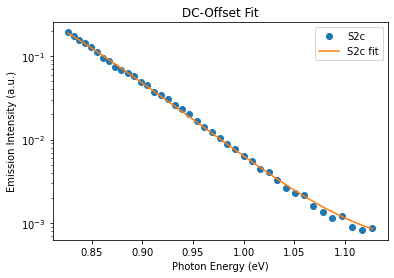

 
Final Fit Calculation
_____________________________________________

Initial Guess Parameters: 
    b = 25.533016021256884
    c = 1403264753.821019

Final Fit Parameters: 
    a = -1.2888080612771448e-07
    b = 25.53294668321444
    c = 1403183400.8768039
    


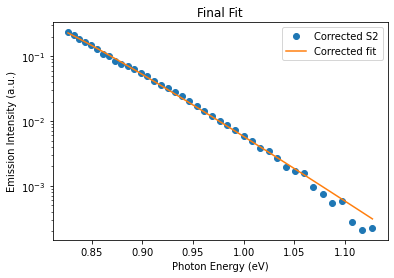

The carrier temperature is 454.4919262757566 K.


In [6]:
# Applying curve fit function 
# DC-offset Correction 
dc_guessb, dc_guessc, dc_fita, dc_fitb, dc_fitc, fig = guess_check('DC-Offset Calculations', new_df['Photon Energy'], new_df['S2c'], 'S2c', 'S2c fit', 'DC-Offset Fit')
# Since dLambda to dE correction is already done with another column, we can skip straight to multiplier correction 
# Multiplier Correction 
new_df['Corrected S2'] = (new_df['dE_Conv S2'] - dc_fita) * new_df['Multiplier']
guessb, guessc, final_a, final_b, final_c, fig = guess_check('Final Fit Calculation', new_df['Photon Energy'], new_df['Corrected S2'], 'Corrected S2', 'Corrected fit', 'Final Fit')
e_temp = 1/(k*final_b)
print(f"The carrier temperature is {e_temp} K.")

    Wavelength       S2c        S2  Photon Energy  Multiplier  dE_Conv S2c  \
1       1100.0  0.000864  0.000769       1.127138    1.122953     0.000766   
2       1110.0  0.000825  0.000747       1.116983    1.104384     0.000739   
3       1120.0  0.000887  0.000814       1.107010    1.089590     0.000801   
4       1130.0  0.001219  0.001131       1.097214    1.077876     0.001111   
5       1140.0  0.001158  0.001083       1.087589    1.069073     0.001065   
6       1150.0  0.001354  0.001275       1.078132    1.062589     0.001256   
7       1160.0  0.001587  0.001498       1.068838    1.058887     0.001484   
8       1170.0  0.002193  0.002071       1.059702    1.058523     0.002069   
9       1180.0  0.002311  0.002181       1.050722    1.059684     0.002199   
10      1190.0  0.002602  0.002450       1.041892    1.062109     0.002497   
11      1200.0  0.003285  0.003085       1.033210    1.064715     0.003179   
12      1210.0  0.004034  0.003781       1.024671    1.066998   

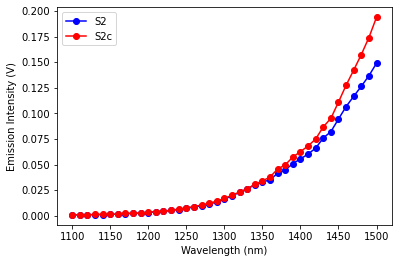

In [22]:
print(new_df)
plt.plot(new_df['Wavelength'], new_df['S2'], '-o', label='S2', color = 'b')
plt.plot(new_df['Wavelength'], new_df['S2c'], '-o', label='S2c', color='r')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Emission Intensity (V)') 
plt.savefig('s2ands2c.png')
plt.show()